In [1]:
import os
import pandas as pd
import xml.etree.ElementTree as ET

# data path
train_dir = r'C:\Users\xiaog\Desktop\Project\Datasets\dataset\split_70_20_10\train'
valid_dir = r'C:\Users\xiaog\Desktop\Project\Datasets\dataset\split_70_20_10\valid'
test_dir = r'C:\Users\xiaog\Desktop\Project\Datasets\dataset\split_70_20_10\test'

In [2]:
# get label
def get_label_from_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    objects = root.findall('object')

    # if exist "thermal_defect", return 1
    for obj in objects:
        if obj.find('name').text == 'thermal_defect':
            return "1"  

    return "0" 

# count defects
def count_defects_in_directory(data_dir):
    with_defect = 0
    without_defect = 0
    
    for root, _, files in os.walk(data_dir):
        for file in files:
            if file.endswith('.xml'):
                xml_path = os.path.join(root, file)
                img_path = os.path.join(root.replace('annotations', 'images'), file.replace('.xml', '.jpg'))

                if os.path.exists(img_path):  
                    label = get_label_from_xml(xml_path)  
                    if label == "1":
                        with_defect += 1
                    else:
                        without_defect += 1
    
    return with_defect, without_defect

def create_dataframe(data_dir):
    data = []
    
    for root, _, files in os.walk(data_dir):
        for file in files:
            if file.endswith('.xml'):
                xml_path = os.path.join(root, file)
                img_path = os.path.join(root.replace('annotations', 'images'), file.replace('.xml', '.jpg'))

                if os.path.exists(img_path):  
                    label = get_label_from_xml(xml_path) 
                    data.append([img_path, label])
    
    return pd.DataFrame(data, columns=['filepath', 'label'])

train_df = create_dataframe(train_dir)
valid_df = create_dataframe(valid_dir)
test_df = create_dataframe(test_dir)

print(f"Train set: {len(train_df)} images")
print(f"Valid set: {len(valid_df)} images")
print(f"Test set: {len(test_df)} images")

train_with_defect, train_without_defect = count_defects_in_directory(train_dir)
valid_with_defect, valid_without_defect = count_defects_in_directory(valid_dir)
test_with_defect, test_without_defect = count_defects_in_directory(test_dir)

print(f"Train set - defect: {train_with_defect}, no_defect: {train_without_defect}")
print(f"Valid set - defect: {valid_with_defect}, no_defect: {valid_without_defect}")
print(f"Test set - defect: {test_with_defect}, no_defect: {test_without_defect}")


Train set: 3748 images
Valid set: 1071 images
Test set: 533 images
Train set - defect: 3321, no_defect: 427
Valid set - defect: 942, no_defect: 129
Test set - defect: 470, no_defect: 63


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

train_datagen = ImageDataGenerator(
    rescale=1./255,  
    rotation_range=30,  
    width_shift_range=0.2,  
    height_shift_range=0.2,  
    shear_range=0.2, 
    zoom_range=0.2, 
    horizontal_flip=True 
)

valid_test_datagen = ImageDataGenerator(rescale=1./255)

# train generator
train_generator_70_20_10 = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="filepath",
    y_col="label",
    target_size=(128, 128),
    batch_size=32,
    class_mode="categorical"  
)

# valid generator
valid_generator_70_20_10 = valid_test_datagen.flow_from_dataframe(
    dataframe=valid_df,
    x_col="filepath",
    y_col="label",
    target_size=(128, 128),
    batch_size=32,
    class_mode="categorical"
)

# test generator
test_generator_70_20_10 = valid_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="filepath",
    y_col="label",
    target_size=(128, 128),
    batch_size=32,
    class_mode="categorical",
    shuffle=False  
)

print(f"Train generator samples: {train_generator_70_20_10.samples}")
print(f"Valid generator samples: {valid_generator_70_20_10.samples}")
print(f"Test generator samples: {test_generator_70_20_10.samples}")

Found 3748 validated image filenames belonging to 2 classes.
Found 1071 validated image filenames belonging to 2 classes.
Found 533 validated image filenames belonging to 2 classes.
Train generator samples: 3748
Valid generator samples: 1071
Test generator samples: 533


In [4]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

def simple_cnn_model(input_shape=(128, 128, 3), num_classes=2):
    inputs = Input(shape=input_shape)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Flatten()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

model = simple_cnn_model(input_shape=(128, 128, 3), num_classes=2)

model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 65536)             0         
                                                                 
 dense (Dense)               (None, 2)                 131074    
                                                                 
Total params: 131,522
Trainable params: 131,522
Non-trainable params: 0
_______________________________________________________

In [5]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall

def focal_loss(gamma=2., alpha=0.75):
    """
    Focal Loss implementation for binary classification.

    Parameters:
        gamma (float): Focusing parameter. Default is 2.
        alpha (float): Weighting factor for class imbalance. Default is 0.75 for better focusing on less frequent class.

    Returns:
        loss (function): Focal loss function.
    """

    def focal_loss_fixed(y_true, y_pred):
        # Clip predictions to avoid log(0)
        y_pred = K.clip(y_pred, K.epsilon(), 1. - K.epsilon())

        # Calculate cross entropy
        cross_entropy = -y_true * K.log(y_pred)

        # Calculate modulating factor (1 - p_t) ^ gamma
        modulating_factor = K.pow(1 - y_pred, gamma)

        # Calculate the focal loss
        loss = alpha * modulating_factor * cross_entropy

        return K.sum(loss, axis=-1)

    return focal_loss_fixed

In [7]:
from tensorflow.keras.callbacks import ReduceLROnPlateau


def compile_model(model, split_name="split_70_20_10"):
    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss=focal_loss(gamma=2., alpha=0.75),
        metrics=[
            'accuracy', 
            Precision(name='precision'), 
            Recall(name='recall'), 
            'AUC']
    )

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
        ModelCheckpoint(
            filepath=f'models/cnn_model_{split_name}.h5',
            monitor='val_loss',
            save_best_only=True,
            mode='min',
            verbose=1
        ),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=1e-6)
    ]

    return callbacks

In [8]:
import pickle
import numpy as np 

def train_and_save_history(train_generator, valid_generator, split_name="split_70_20_10", epochs=50, batch_size=32):
    steps_per_epoch = train_generator.samples // batch_size
    validation_steps = valid_generator.samples // batch_size

   # compile model
    model = simple_cnn_model() 

    callbacks = compile_model(model, split_name)

    history = model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        validation_data=valid_generator,
        validation_steps=validation_steps,
        epochs=epochs,
        callbacks=callbacks
    )

    # save history
    history_path = f"models/cnn_model_{split_name}.pkl"
    with open(history_path, 'wb') as f:  
        pickle.dump(history.history, f)

    print(f"basic_cnn_model history for {split_name} saved as {history_path}")


# train `split_70_20_10` and save history
train_and_save_history(train_generator_70_20_10, valid_generator_70_20_10, split_name="split_70_20_10")

Epoch 1/50
117/117 [==============================] - ETA: 0s - loss: 0.0797 - accuracy: 0.8724 - precision: 0.8724 - recall: 0.8724 - auc: 0.9008
Epoch 1: val_loss improved from inf to 0.08501, saving model to models\cnn_model_split_70_20_10.h5
117/117 [==============================] - 84s 676ms/step - loss: 0.0797 - accuracy: 0.8724 - precision: 0.8724 - recall: 0.8724 - auc: 0.9008 - val_loss: 0.0850 - val_accuracy: 0.8381 - val_precision: 0.8381 - val_recall: 0.8381 - val_auc: 0.8979 - lr: 1.0000e-04
Epoch 2/50
117/117 [==============================] - ETA: 0s - loss: 0.0729 - accuracy: 0.8829 - precision: 0.8829 - recall: 0.8829 - auc: 0.9104
Epoch 2: val_loss improved from 0.08501 to 0.07060, saving model to models\cnn_model_split_70_20_10.h5
117/117 [==============================] - 91s 778ms/step - loss: 0.0729 - accuracy: 0.8829 - precision: 0.8829 - recall: 0.8829 - auc: 0.9104 - val_loss: 0.0706 - val_accuracy: 0.8778 - val_precision: 0.8778 - val_recall: 0.8778 - val_auc

In [9]:
from tensorflow.keras.models import load_model

# load model and loss function
model = load_model(
    'models/cnn_model_split_70_20_10.h5',
    custom_objects={'focal_loss_fixed': focal_loss(gamma=2., alpha=0.75)}  
)

# evaluation
test_loss, test_accuracy, test_precision, test_recall, test_auc = model.evaluate(test_generator_70_20_10, verbose=1)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Test AUC: {test_auc}")


17/17 [==============================] - 8s 402ms/step - loss: 0.0556 - accuracy: 0.9118 - precision: 0.9118 - recall: 0.9118 - auc: 0.9565
Test Loss: 0.05560336261987686
Test Accuracy: 0.9118198752403259
Test Precision: 0.9118198752403259
Test Recall: 0.9118198752403259
Test AUC: 0.9565294981002808


1/1 [==============================] - 0s 67ms/step
Sensitivity (Recall): 0.9977272727272727
Specificity: 0.2786885245901639
Confusion matrix saved at: C:\Users\xiaog\Desktop\Project\Datasets\dataset\Performance\CNN\confusion_matrix_inception.png


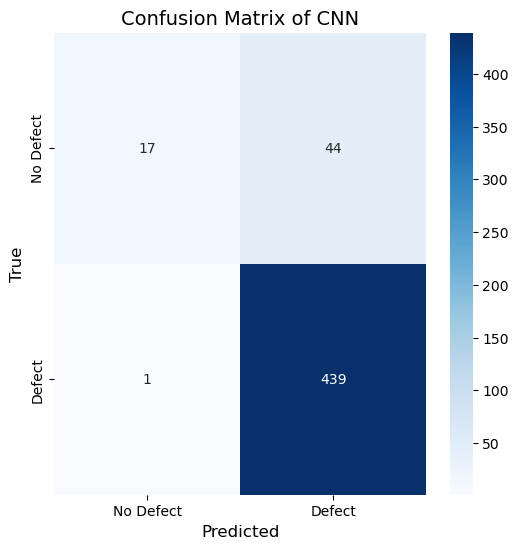

In [10]:
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import os
import matplotlib.pyplot as plt


save_dir = r"C:\Users\xiaog\Desktop\Project\Datasets\dataset\Performance\CNN"
os.makedirs(save_dir, exist_ok=True)

test_steps = test_generator_70_20_10.samples // test_generator_70_20_10.batch_size  
y_true = []
y_pred = []

# get prediction result
for _ in range(test_steps):
    x, y = test_generator_70_20_10.next()
    predictions = model.predict(x)
    
    # get true label
    y_true.extend(np.argmax(y, axis=1)) 
    # get prediction label
    y_pred.extend(np.argmax(predictions, axis=1))


# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Calculate sensitivity (Recall) and specificity
TP = cm[1, 1] 
TN = cm[0, 0]  
FP = cm[0, 1]  
FN = cm[1, 0]  

sensitivity = TP / float(TP + FN)
specificity = TN / float(TN + FP)

print(f'Sensitivity (Recall): {sensitivity}')
print(f'Specificity: {specificity}')

# Plot the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Defect', 'Defect'], yticklabels=['No Defect', 'Defect'])
plt.title('Confusion Matrix of CNN', fontsize=14)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)

# Save the confusion matrix plot
confusion_matrix_path = os.path.join(save_dir, 'confusion_matrix_inception.png')
plt.savefig(confusion_matrix_path, dpi=600, bbox_inches='tight')

# Print the saved path
print(f"Confusion matrix saved at: {confusion_matrix_path}")

# Show the plot
plt.show()


In [8]:
from sklearn.metrics import f1_score
import numpy as np

test_steps = test_generator_70_20_10.samples // test_generator_70_20_10.batch_size
y_true = []
y_pred = []

for _ in range(test_steps):
    x, y = test_generator_70_20_10.next()
    predictions = model.predict(x)
    y_true.extend(np.argmax(y, axis=1))              
    y_pred.extend(np.argmax(predictions, axis=1))   

f1 = f1_score(y_true, y_pred, average='binary') 
print(f'F1 Score: {f1:.4f}')

1/1 [==============================] - 0s 55ms/step
F1 Score: 0.9581
